In [1]:
import datasets
import evaluate
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from transformers import Trainer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

In [2]:
finer = datasets.load_dataset("nlpaueb/finer-139")

## Entities Distribution

In [3]:
finer_train = finer['train']
finer_test = finer['test']
finer_validation = finer['validation']

In [4]:
entities_names = finer_train.features["ner_tags"].feature.names

In [5]:
dict_entities = {}

In [6]:
def distribution_entities(row):
    for ner_tag in row['ner_tags']:
        if ner_tag!=0:
            if ner_tag in dict_entities:
                dict_entities[ner_tag]+=1
            else:
                dict_entities[ner_tag]=1

In [7]:
finer.map(distribution_entities)
dict_sorted_finer_entities = dict(sorted(dict_entities.items(), key= lambda item: item[1], reverse=True))

Map:   0%|          | 0/900384 [00:00<?, ? examples/s]

Map:   0%|          | 0/112494 [00:00<?, ? examples/s]

Map:   0%|          | 0/108378 [00:00<?, ? examples/s]

In [8]:
dict_sorted_finer_entities

{41: 18448,
 87: 14730,
 34: 14469,
 37: 13158,
 4: 10160,
 8: 9162,
 57: 8684,
 6: 7458,
 30: 6779,
 140: 5763,
 74: 5485,
 64: 5473,
 43: 5319,
 128: 5277,
 55: 4773,
 83: 4543,
 60: 4446,
 107: 4328,
 102: 4158,
 129: 4006,
 82: 3859,
 35: 3833,
 59: 3792,
 32: 3770,
 138: 3720,
 17: 3688,
 90: 3616,
 70: 3597,
 105: 3551,
 131: 3540,
 53: 3539,
 158: 3406,
 88: 3253,
 113: 3178,
 139: 3026,
 40: 2954,
 80: 2913,
 132: 2774,
 58: 2659,
 133: 2598,
 142: 2550,
 145: 2528,
 44: 2460,
 152: 2450,
 124: 2407,
 67: 2400,
 99: 2375,
 156: 2372,
 147: 2369,
 16: 2339,
 165: 2331,
 85: 2281,
 100: 2216,
 25: 2195,
 2: 2195,
 91: 2114,
 66: 2093,
 14: 2062,
 31: 2013,
 50: 1942,
 168: 1941,
 51: 1895,
 12: 1879,
 72: 1873,
 89: 1868,
 52: 1866,
 119: 1852,
 94: 1779,
 42: 1773,
 77: 1768,
 137: 1762,
 18: 1757,
 98: 1749,
 159: 1728,
 45: 1726,
 144: 1725,
 97: 1650,
 92: 1647,
 69: 1647,
 62: 1631,
 78: 1619,
 149: 1582,
 148: 1556,
 39: 1540,
 22: 1533,
 73: 1530,
 71: 1517,
 93: 1508,
 13

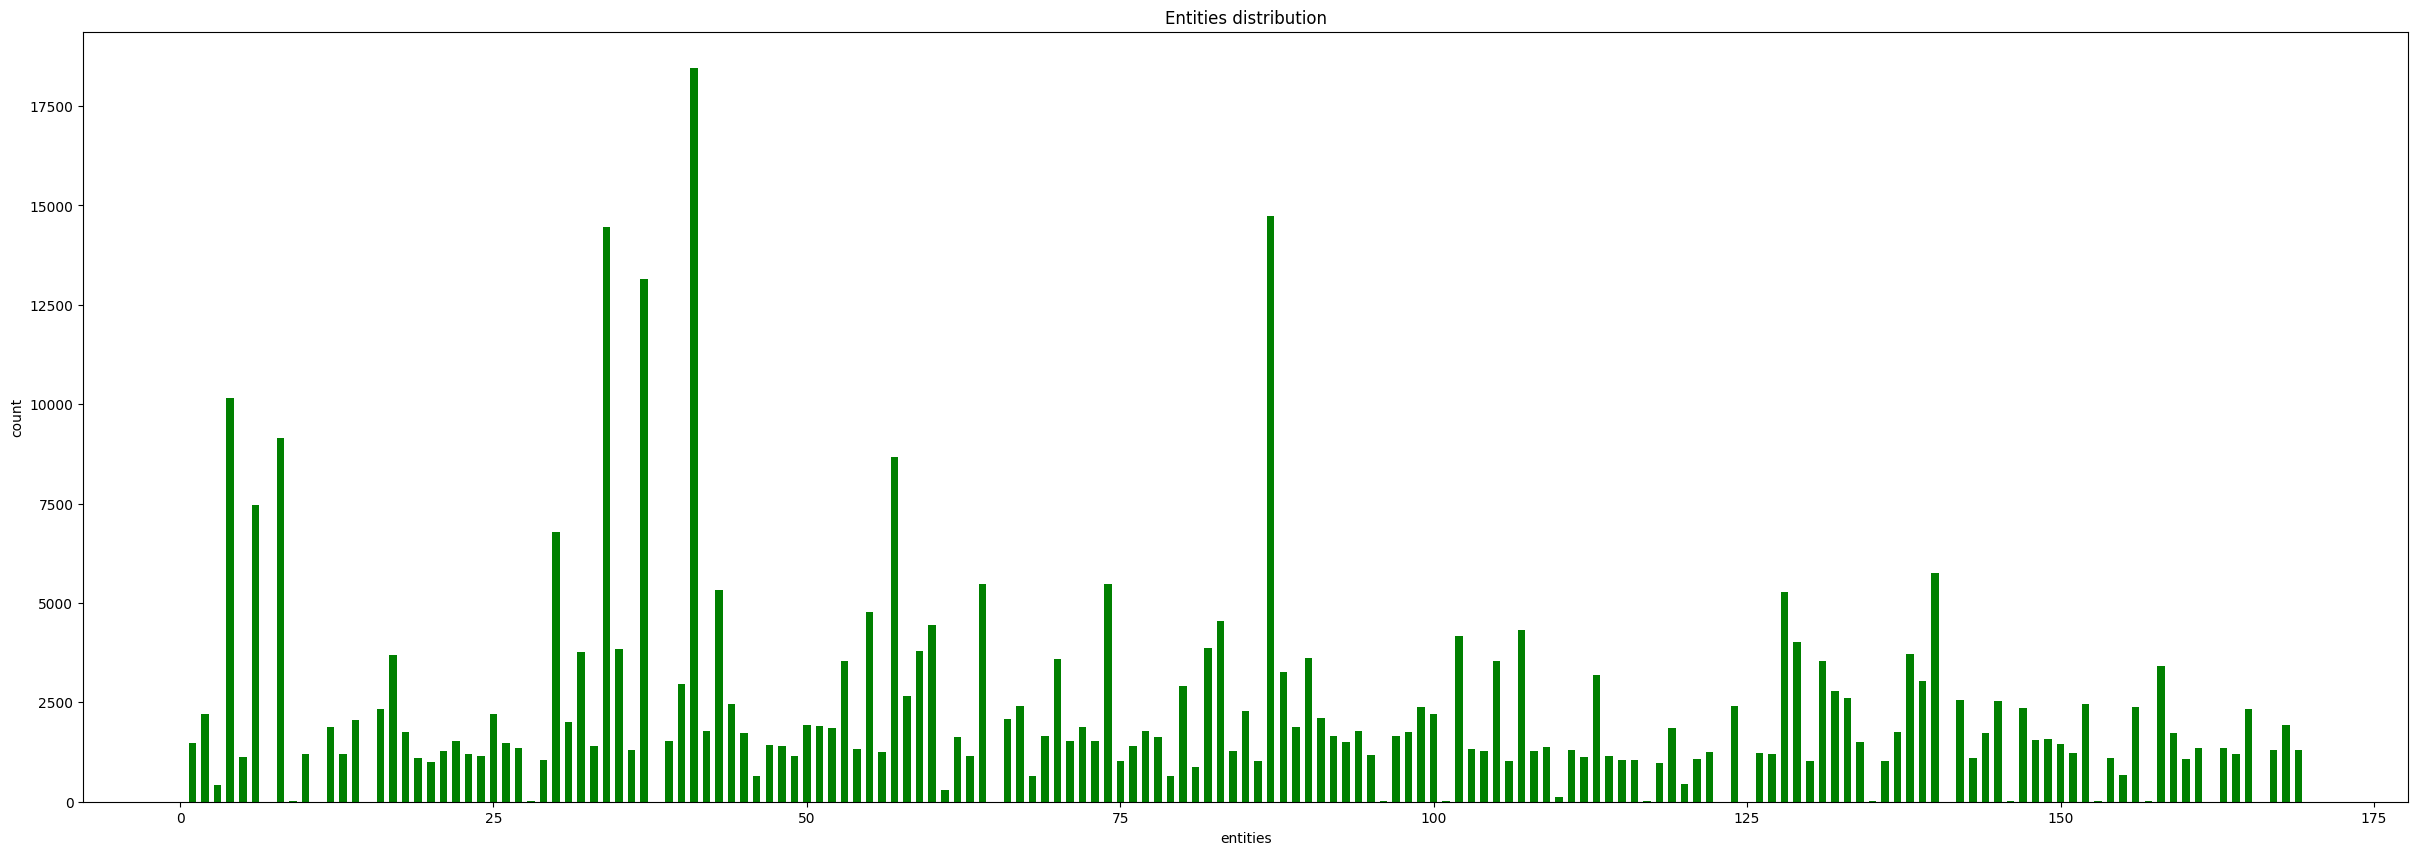

In [9]:
fig = plt.figure(figsize = (30, 10))
plt.bar(dict_entities.keys(), dict_entities.values(), color ='green', width = 0.6)
plt.xlabel("entities")
plt.ylabel("count")
plt.title("Entities distribution")
plt.show()

## Most repeated entities

In [10]:
dict_mapping = {0:0, 41:1, 87:2, 34:3, 37:4}

In [11]:
# O means the word doesn’t correspond to any entity.
# B-XXX means the word corresponds to the beginning of a XXX entity.

In [12]:
entity2index  = { entities_names[value]: dict_mapping[value] for value in [0, 41, 87, 34, 37]} 
entity2index

{'O': 0,
 'B-DebtInstrumentInterestRateStatedPercentage': 1,
 'B-LineOfCreditFacilityMaximumBorrowingCapacity': 2,
 'B-DebtInstrumentBasisSpreadOnVariableRate1': 3,
 'B-DebtInstrumentFaceAmount': 4}

In [13]:
index2entity = { dict_mapping[value]: entities_names[value]  for value in [0, 41, 87, 34, 37]} 

In [14]:
index2entity

{0: 'O',
 1: 'B-DebtInstrumentInterestRateStatedPercentage',
 2: 'B-LineOfCreditFacilityMaximumBorrowingCapacity',
 3: 'B-DebtInstrumentBasisSpreadOnVariableRate1',
 4: 'B-DebtInstrumentFaceAmount'}

## Create new dataset with most repeated entities

In [15]:
def create_dataset(row):
    new_row_ner_tags = []
    for tag in row['ner_tags']:
        if tag in [0, 41, 87, 34, 37]:
            new_row_ner_tags.append(dict_mapping[tag])
        else:
            new_row_ner_tags.append(0)
    row['ner_tags'] = new_row_ner_tags
    return row

In [16]:
new_finer = finer.map(create_dataset)

In [17]:
new_finer

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 900384
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 112494
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 108378
    })
})

In [18]:
new_finer_entities = new_finer.filter(lambda row: 1 in row['ner_tags'] or
                                                  2 in row['ner_tags'] or
                                                  3 in row['ner_tags'] or
                                                  4 in row['ner_tags'] )

In [19]:
new_finer_entities

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3053
    })
})

In [20]:
new_finer_entities

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3053
    })
})

In [21]:
print(new_finer_entities['train'][0]['ner_tags'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [22]:
print(new_finer_entities['train'][0]['tokens'])

['As', 'of', 'November', '30', ',', '2015', ',', '$', '151.8', 'million', 'of', 'the', 'originated', 'loans', 'were', 'sold', 'into', 'a', 'securitization', 'trust', 'but', 'not', 'settled', 'and', 'thus', 'were', 'included', 'as', 'receivables', ',', 'net', '.', 'Notes', 'and', 'Other', 'Debts', 'Payable', 'In', 'November', '2013', ',', 'the', 'Rialto', 'segment', 'originally', 'issued', '$', '250', 'million', 'aggregate', 'principal', 'amount', 'of', 'the', '7.00', '%', 'senior', 'notes', 'due', '2018', '(', '"', '7.00', '%', 'Senior', 'Notes', '"', ')', ',', 'at', 'a', 'price', 'of', '100', '%', 'in', 'a', 'private', 'placement', '.']


## Add entities names to dataset

In [23]:
def add_entities_names(row):
  tag_name = {'ner_tags_name': [index2entity[idx] for idx in row['ner_tags']]}
  return tag_name

In [24]:
new_finer_dataset = new_finer_entities.map(add_entities_names)

In [25]:
new_finer_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'ner_tags_name'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'ner_tags_name'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'ner_tags_name'],
        num_rows: 3053
    })
})

In [26]:
print(new_finer_dataset['train'][0]['ner_tags'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
print(new_finer_dataset['train'][0]['ner_tags_name'])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentFaceAmount', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentInterestRateStatedPercentage', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


# Load Model distilbert-base

In [28]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

In [29]:
tokenizer.is_fast

True

In [30]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [31]:
first_sample = new_finer_dataset['train'][0]['tokens']

In [32]:
print(first_sample)

['As', 'of', 'November', '30', ',', '2015', ',', '$', '151.8', 'million', 'of', 'the', 'originated', 'loans', 'were', 'sold', 'into', 'a', 'securitization', 'trust', 'but', 'not', 'settled', 'and', 'thus', 'were', 'included', 'as', 'receivables', ',', 'net', '.', 'Notes', 'and', 'Other', 'Debts', 'Payable', 'In', 'November', '2013', ',', 'the', 'Rialto', 'segment', 'originally', 'issued', '$', '250', 'million', 'aggregate', 'principal', 'amount', 'of', 'the', '7.00', '%', 'senior', 'notes', 'due', '2018', '(', '"', '7.00', '%', 'Senior', 'Notes', '"', ')', ',', 'at', 'a', 'price', 'of', '100', '%', 'in', 'a', 'private', 'placement', '.']


In [33]:
first_sample_tokens = tokenizer(first_sample, is_split_into_words=True)
print(first_sample_tokens.tokens())

['[CLS]', 'As', 'of', 'November', '30', ',', '2015', ',', '$', '151', '.', '8', 'million', 'of', 'the', 'originated', 'loans', 'were', 'sold', 'into', 'a', 'se', '##cu', '##rit', '##ization', 'trust', 'but', 'not', 'settled', 'and', 'thus', 'were', 'included', 'as', 're', '##ce', '##ivable', '##s', ',', 'net', '.', 'Notes', 'and', 'Other', 'De', '##bt', '##s', 'Pay', '##able', 'In', 'November', '2013', ',', 'the', 'R', '##ial', '##to', 'segment', 'originally', 'issued', '$', '250', 'million', 'aggregate', 'principal', 'amount', 'of', 'the', '7', '.', '00', '%', 'senior', 'notes', 'due', '2018', '(', '"', '7', '.', '00', '%', 'Senior', 'Notes', '"', ')', ',', 'at', 'a', 'price', 'of', '100', '%', 'in', 'a', 'private', 'placement', '.', '[SEP]']


In [34]:
print(first_sample_tokens.word_ids())

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 18, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 35, 35, 36, 36, 37, 38, 39, 40, 41, 42, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 54, 54, 55, 56, 57, 58, 59, 60, 61, 62, 62, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, None]


In [35]:
first_sample_tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [36]:
print(first_sample_tokens['attention_mask'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [37]:
def padding_ner_tags(ner_tags, word_ids, fill_complete_word=True):
  new_ner_tags = []
  previous_word_id = None
  for word_id in word_ids:
    if word_id is None:
      # Special tokens ([CLS], [SEP]) have a word_id that is None, 
      # they are set to -100 to be ignored in the loss function.
      new_ner_tags.append(-100)
    elif word_id != previous_word_id:
      new_ner_tags.append(ner_tags[word_id])
    else:
      # if fill_complete_word=True, pad with ner_tags[word_id] value the complete word
      new_ner_tags.append(ner_tags[word_id] if fill_complete_word else -100)
    previous_word_id = word_id
  return new_ner_tags

In [38]:
first_sample_ner_tags = new_finer_dataset['train'][0]['ner_tags']
first_sample_word_ids = first_sample_tokens.word_ids()


In [39]:
print(first_sample_ner_tags)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [40]:
print(first_sample_word_ids)

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 18, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 35, 35, 36, 36, 37, 38, 39, 40, 41, 42, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 54, 54, 55, 56, 57, 58, 59, 60, 61, 62, 62, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, None]


In [41]:
first_sample_padded_ner_tags = padding_ner_tags(first_sample_ner_tags, first_sample_word_ids)

In [42]:
def batch_tokenize_padding(rows):
  rows_tokenized = tokenizer(rows['tokens'], truncation=True, is_split_into_words=True)
  rows_ner_tags = rows['ner_tags']
  new_labels = []
  for i, ner_tags in enumerate(rows_ner_tags):
    word_ids = rows_tokenized.word_ids(i)
    new_labels.append(padding_ner_tags(ner_tags, word_ids, fill_complete_word=True))
  rows_tokenized['labels'] = new_labels
  return rows_tokenized

In [43]:
# Padding ner_tags and tokenize, additionally remove 'id', 'tokens', 'ner_tags', 'ner_tags_name' 
tokenized_datasets = new_finer_dataset.map(batch_tokenize_padding, batched=True, remove_columns=new_finer_dataset['train'].column_names)

In [44]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3053
    })
})

In [45]:
# Data collator that will dynamically pad the inputs received, as well as the labels. 
# The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [46]:
data_collator

DataCollatorForTokenClassification(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token

In [47]:
dynamic_padding_example = data_collator([tokenized_datasets['train'][i] for i in range(0,2)])
dynamic_padding_example

{'input_ids': tensor([[  101,  1249,  1104,  1379,  1476,   117,  1410,   117,   109, 17576,
           119,   129,  1550,  1104,  1103,  7506, 11453,  1127,  1962,  1154,
           170, 14516, 10182,  7729,  2734,  3496,  1133,  1136,  3035,  1105,
          2456,  1127,  1529,  1112,  1231,  2093, 25768,  1116,   117,  5795,
           119,  8797,  1105,  2189,  3177, 21238,  1116, 22531,  1895,  1130,
          1379,  1381,   117,  1103,   155,  2916,  2430,  6441,  2034,  3010,
           109,  4805,  1550,  9453,  3981,  2971,  1104,  1103,   128,   119,
          3135,   110,  2682,  3697,  1496,  1857,   113,   107,   128,   119,
          3135,   110,  4308,  8797,   107,   114,   117,  1120,   170,  3945,
          1104,  1620,   110,  1107,   170,  2029, 12693,   119,   102],
        [  101,  1130,  1345,  1387,   117,  1103,   155,  2916,  2430,  6441,
          3010,  1126,  2509,   109,  1620,  1550,  1104,  1103,   128,   119,
          3135,   110,  4308,  8797,   117, 

In [48]:
print(dynamic_padding_example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [49]:
metric = evaluate.load('seqeval')
#metric = datasets.load_metric("seqeval")

In [50]:
first_sample_ner_tags = new_finer_dataset['train'][0]['ner_tags']

In [51]:
print(first_sample_ner_tags)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
ner_tags_names_first_sample = [index2entity[ner_tag] for ner_tag in first_sample_ner_tags]
print(ner_tags_names_first_sample)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentFaceAmount', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentInterestRateStatedPercentage', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [53]:
predictions_first_sample = ner_tags_names_first_sample.copy()

In [54]:
predictions_first_sample[0] = 'B-DebtInstrumentFaceAmount'
predictions_first_sample[1] = 'B-DebtInstrumentInterestRateStatedPercentage'

In [55]:
print(predictions_first_sample)

['B-DebtInstrumentFaceAmount', 'B-DebtInstrumentInterestRateStatedPercentage', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentFaceAmount', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentInterestRateStatedPercentage', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [56]:
metric.compute(predictions=[predictions_first_sample], references=[ner_tags_names_first_sample])

{'DebtInstrumentFaceAmount': {'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'number': 1},
 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'number': 1},
 'overall_precision': 0.5,
 'overall_recall': 1.0,
 'overall_f1': 0.6666666666666666,
 'overall_accuracy': 0.975}

# Finetunning

In [57]:
index2entity

{0: 'O',
 1: 'B-DebtInstrumentInterestRateStatedPercentage',
 2: 'B-LineOfCreditFacilityMaximumBorrowingCapacity',
 3: 'B-DebtInstrumentBasisSpreadOnVariableRate1',
 4: 'B-DebtInstrumentFaceAmount'}

In [58]:
entity2index

{'O': 0,
 'B-DebtInstrumentInterestRateStatedPercentage': 1,
 'B-LineOfCreditFacilityMaximumBorrowingCapacity': 2,
 'B-DebtInstrumentBasisSpreadOnVariableRate1': 3,
 'B-DebtInstrumentFaceAmount': 4}

In [59]:
model = AutoModelForTokenClassification.from_pretrained( "distilbert-base-cased", id2label=index2entity, label2id=entity2index)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
model.config.num_labels

5

In [61]:
model

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [62]:
finetunned_ner_classifier_distil_bert = 'ner-classifier-distil-bert'
args = TrainingArguments(finetunned_ner_classifier_distil_bert,
                         evaluation_strategy = "epoch",
                         save_strategy="epoch",
                         learning_rate = 2e-5,
                         num_train_epochs=5,
                         weight_decay=0.01,
                         logging_steps=50 # default 500
                        )

In [63]:
tokenized_datasets['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 28363
})

In [64]:
train_dataset = tokenized_datasets['train'].select(range(2500))
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2500
})

In [65]:
tokenized_datasets['validation']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3741
})

In [66]:
eval_dataset = tokenized_datasets['validation'].select(range(500))
eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 500
})

In [67]:
def compute_metrics(eval_preds):
  logits, labels = eval_preds
  #print(f'labels.shape: {labels.shape}')
  #print(f'logits.shape: {logits.shape}')
  #print(f'logits: {logits}')
  #print(f'labels: {labels}')
  predictions = np.argmax(logits, axis=2)
  #print(f'predictions: {predictions}')
  #print(f'predictions.shape: {predictions.shape}')
  true_labels = [[index2entity[l] for l in label if l!=-100] for label in labels]
  #print(f'true_labels: {true_labels}')
  #print(f'true_labels.len: {len(true_labels[0])}')
  true_predictions = [[index2entity[p] for p,l in zip(prediction, label) if l!=-100] for prediction, label in zip(predictions, labels)]
  #print(f'true_predictions: {true_predictions}')
  #print(f'true_predictions.len: {len(true_predictions[0])}')
  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
  print(f'all_metrics: {all_metrics}')
  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

In [68]:
trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer)

In [69]:
trainer.train()

  0%|          | 0/1565 [00:00<?, ?it/s]

{'loss': 0.3884, 'grad_norm': 0.5011580586433411, 'learning_rate': 1.9361022364217256e-05, 'epoch': 0.16}
{'loss': 0.0914, 'grad_norm': 0.5986570715904236, 'learning_rate': 1.8722044728434506e-05, 'epoch': 0.32}
{'loss': 0.0743, 'grad_norm': 0.9875678420066833, 'learning_rate': 1.808306709265176e-05, 'epoch': 0.48}
{'loss': 0.0535, 'grad_norm': 0.7359943985939026, 'learning_rate': 1.744408945686901e-05, 'epoch': 0.64}
{'loss': 0.0484, 'grad_norm': 0.938058614730835, 'learning_rate': 1.6805111821086264e-05, 'epoch': 0.8}
{'loss': 0.0429, 'grad_norm': 1.3367325067520142, 'learning_rate': 1.6166134185303515e-05, 'epoch': 0.96}


  0%|          | 0/63 [00:00<?, ?it/s]

all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.7440677966101695, 'recall': 0.9606126914660832, 'f1': 0.8385864374403057, 'number': 457}, 'DebtInstrumentFaceAmount': {'precision': 0.7807692307692308, 'recall': 0.4356223175965665, 'f1': 0.559228650137741, 'number': 466}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.9021852237252862, 'recall': 0.9517014270032931, 'f1': 0.9262820512820514, 'number': 911}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.6866952789699571, 'recall': 0.9073724007561437, 'f1': 0.7817589576547231, 'number': 529}, 'overall_precision': 0.7924302788844622, 'overall_recall': 0.841726618705036, 'overall_f1': 0.8163349066283603, 'overall_accuracy': 0.9791696148076868}
{'eval_loss': 0.062302179634571075, 'eval_precision': 0.7924302788844622, 'eval_recall': 0.841726618705036, 'eval_f1': 0.8163349066283603, 'eval_accuracy': 0.9791696148076868, 'eval_runtime': 8.7869, 'eval_samples_per_second': 56.903, 'eval_step

RuntimeError: MPS backend out of memory (MPS allocated: 5.20 GB, other allocations: 12.86 GB, max allowed: 18.13 GB). Tried to allocate 84.95 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model(finetunned_ner_classifier_distil_bert)

In [ ]:
#trainer.push_to_hub(commit_message="Training first version")

## Predict a sample

In [ ]:
test_sample = ' '.join( new_finer_dataset['test'][0]['tokens'])
test_sample

In [ ]:
test_sample[93:95]

In [ ]:
ner_classifier = pipeline(
    "token-classification", model=finetunned_ner_classifier_distil_bert, aggregation_strategy="simple"
)
ner_classifier(test_sample)

## Evaluate on test set

In [ ]:
saved_tokenizer = AutoTokenizer.from_pretrained(finetunned_ner_classifier_distil_bert)

In [ ]:
saved_tokenizer

In [ ]:
saved_model = AutoModelForTokenClassification.from_pretrained(finetunned_ner_classifier_distil_bert, num_labels=len(index2entity))

In [ ]:
saved_model

In [ ]:
tokens_test_sample = saved_tokenizer(test_sample)

In [ ]:
preds_logits = saved_model.forward(input_ids=torch.tensor(tokens_test_sample['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens_test_sample['attention_mask']).unsqueeze(0))

In [ ]:
preds_logits

In [ ]:
preds = torch.argmax(preds_logits.logits.squeeze(), axis=1)

In [ ]:
preds

In [ ]:
words = saved_tokenizer.batch_decode(tokens_test_sample['input_ids'])

In [ ]:
print(words)

In [ ]:
value_preds = [index2entity[int(i)] for i in preds]

In [ ]:
print(value_preds)

In [ ]:
def predict_sample(row):
    text = row['tokens']
    print(f'len(text): {len(text):}')
    tokens_sample = saved_tokenizer(text, is_split_into_words=True)
    print(f'tokens_sample: {tokens_sample}')
    prediction_logits_sample = saved_model.forward(input_ids=torch.tensor(tokens_sample['input_ids']).unsqueeze(0), 
                                attention_mask=torch.tensor(tokens_sample['attention_mask']).unsqueeze(0))
    print(f'prediction_logits_sample: {prediction_logits_sample}')
    prediction_sample = torch.argmax(prediction_logits_sample.logits.squeeze(), axis=1)
    value_preds = [index2entity[int(i)] for i in prediction_sample]
    return value_preds


In [ ]:
print(predict_sample(new_finer_dataset['test'][0]))

In [ ]:
new_finer_dataset['test']

In [ ]:
def predict_tokenized_sample(rows):
    #print(f"rows[input_ids]: {rows['input_ids']}")
    #print(f"rows[attention_mask]: {rows['attention_mask']}")
    logits = saved_model.forward(input_ids=torch.tensor(rows['input_ids']).unsqueeze(0), 
                                attention_mask=torch.tensor(rows['attention_mask']).unsqueeze(0))    
    #print(f'logits: {logits}')
    value_preds = torch.argmax(logits.logits.squeeze(), axis=1)
    #print(f'value_preds: {value_preds}')
    #entity_pred = [index2entity[int(i)] for i in value_preds]
    #print(f'entity_preds: {entity_pred}')
    rows['value_preds'] = value_preds
    return rows
    

In [ ]:
test_dataset = tokenized_datasets['test'].select(range(1000))

In [ ]:
predicted_test_dataset = test_dataset.map(predict_tokenized_sample)

In [ ]:
value_preds = predicted_test_dataset['value_preds']

In [ ]:
labels = predicted_test_dataset['labels']

In [ ]:
def compute_metrics(eval_preds):
  value_preds, labels = eval_preds
  #print(f'value_preds: {value_preds}')
  #print(f'labels: {labels}')
  true_labels = [[index2entity[l] for l in label if l!=-100] for label in labels]
  #print(f'true_labels: {true_labels}')
  #print(f'true_labels.len: {len(true_labels[0])}')
  true_predictions = [[index2entity[p] for p,l in zip(value_preds, label) if l!=-100] for value_preds, label in zip(value_preds, labels)]
  #print(f'true_predictions: {true_predictions}')
  #print(f'true_predictions.len: {len(true_predictions[0])}')
  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
  print(f'all_metrics: {all_metrics}')
  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

In [72]:
compute_metrics((value_preds, labels))

NameError: name 'value_preds' is not defined

## Export to OONX

In [71]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

In [ ]:
model_checkpoint = "distilbert_base_uncased_squad"
save_directory = "onnx/"

# Load a model from transformers and export it to ONNX
ort_model = ORTModelForSequenceClassification.from_pretrained(model_checkpoint, export=True)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Save the onnx model and tokenizer
ort_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)